In [47]:
!pip install torch torchvision numpy matplotlib grad-cam scipy


In [48]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import resnet18
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import preprocess_image
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
from torchvision.utils import save_image
from torch.autograd import Variable
import pylab


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [50]:

# Load CIFAR-10 dataset
# Run this to download the data into "./data" folder
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## Classifier (Pretrained MobileNetV2)

In [51]:
import torch
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_mobilenetv2_x1_0", pretrained=True)
print("Loaded Pretrained MobileNetV2 on CIFAR-10!")
  
model = model.to(device)
model.eval()


Loaded Pretrained MobileNetV2 on CIFAR-10!


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

### Gradcam initialization on MobileNetV2

In [52]:
target_layer = model.features[-1]  # Last convolutional layer

# Initialize Grad-CAM with the it
from pytorch_grad_cam import GradCAM
cam = GradCAM(model=model, target_layers=[target_layer])

print("Grad-CAM initialized correctly for MobileNetV2")


Grad-CAM initialized correctly for MobileNetV2


### Accuracy of MNv2

In [65]:
import torch

def calculate_accuracy(model, dataloader, device):
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():  
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get class with highest probability
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

# Compute accuracy on test set
test_accuracy = calculate_accuracy(model, testloader, device)
print(f"ᕙ(▀̿̿ĺ̯̿̿▀̿ ̿) ᕗ MobileNetv2 Model Test Accuracy: {test_accuracy:.4f}")


ᕙ(▀̿̿ĺ̯̿̿▀̿ ̿) ᕗ MobileNetv2 Model Test Accuracy: 0.8415


## GAN (Pretrained on CIFAR-10 dataset)

In [54]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

class Generator(nn.Module):
    def __init__(self, ngpu, nc=3, nz=100, ngf=64):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [55]:
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

### Load weights

In [56]:
# %load_ext autoreload
# %autoreload 2

num_gpu = 1 if torch.cuda.is_available() else 0

D = Discriminator(ngpu=1).eval()
G = Generator(ngpu=1).eval()

# https://github.com/csinva/gan-vae-pretrained-pytorch/blob/master/cifar10_dcgan/dcgan_cifar10_pretrained_load.ipynb
# load weights
D.load_state_dict(torch.load('/kaggle/input/dcgan-discriminator/pytorch/default/1/netD_epoch_199.pth'))
G.load_state_dict(torch.load('/kaggle/input/dcgan-generator/pytorch/default/1/netG_epoch_199.pth'))
if torch.cuda.is_available():
    D = D.cuda()
    G = G.cuda()

<ipython-input-56-cb208e1175b2>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  D.load_state_dict(torch.load('/kaggle/input/dcgan-discriminator/pytorch/default/1/netD_epoc

### Visualize some images 

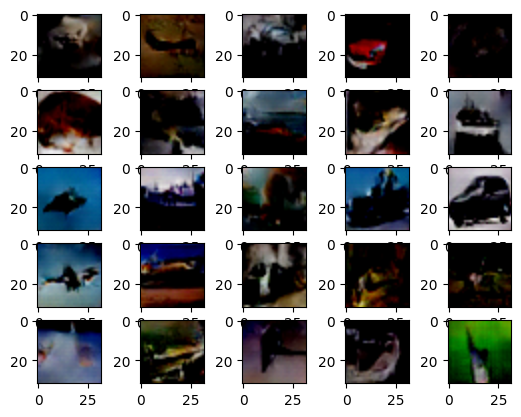

tensor([5.1696e-02, 5.4170e-04, 3.1916e-02, 2.4393e-05, 8.0975e-02, 6.0705e-03,
        6.5110e-03, 8.1004e-02, 2.6489e-03, 3.7226e-03, 8.1458e-03, 4.4112e-03,
        5.6497e-03, 2.5488e-03, 2.0498e-04, 1.9765e-01, 7.7236e-02, 2.4557e-04,
        1.6632e-02, 3.2490e-02, 4.3985e-03, 2.9587e-05, 1.1218e-03, 1.7856e-04,
        7.6046e-01], device='cuda:0', grad_fn=<SqueezeBackward1>)


In [57]:
batch_size = 25
latent_size = 100

fixed_noise = torch.randn(batch_size, latent_size, 1, 1)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
fake_images = G(fixed_noise)


# z = torch.randn(batch_size, latent_size).cuda()
# z = Variable(z)
# fake_images = G(z)

fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 3, 32, 32)
fake_images_np = fake_images_np.transpose((0, 2, 3, 1))
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i + 1)
    plt.imshow(fake_images_np[i], interpolation='bilinear')
plt.show()

outputs = D(fake_images)
print(outputs)

## GradCAM

In [58]:

# Function to generate Grad-CAM heatmaps
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def generate_gradcam_heatmap(image, class_idx):
    # Detach from computation graph before converting to NumPy
    image_np = image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Normalize and preprocess for Grad-CAM
    input_tensor = preprocess_image(image_np, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    
    # Wrap class_idx properly
    target = [ClassifierOutputTarget(class_idx)]
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]
    return grayscale_cam

In [59]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_pairs = 10  # Number of real-fake pairs
real_fake_pairs = []  # Store pairs of (real, fake, real_label)
z_dim = 100
for i in range(num_pairs):
    # Select a real image
    real_image, real_label = testset[i]
    real_image = real_image.unsqueeze(0).to(device)

    # Generate multiple fake images & find one with the same class
    num_samples = 100  # Generate many fake images to find a match
    noise = torch.randn(num_samples, z_dim, 1, 1, device=device)
    fake_images = G(noise).detach()

    matched_fake_image = None
    for fake_img in fake_images:
        img = fake_img.unsqueeze(0).to(device)
        output = model(img)
        predicted_label = output.argmax(dim=1).item()

        if predicted_label == real_label:  # ✅ Match class
            matched_fake_image = img
            break

    if matched_fake_image is not None:
        real_fake_pairs.append((real_image, matched_fake_image, real_label))
    else:
        print(f":( No match found for pair {i+1}, skipping.")

print(f":) Found {len(real_fake_pairs)} real-fake pairs with matching classes.")


:) Found 10 real-fake pairs with matching classes.


In [60]:
ssim_scores = []
pearson_scores = []

for i, (real_image, fake_image, real_label) in enumerate(real_fake_pairs):
    # Grad-CAM heatmaps
    real_heatmap = generate_gradcam_heatmap(real_image, real_label)
    fake_heatmap = generate_gradcam_heatmap(fake_image, real_label)

    # Resize for fair comparison
    real_heatmap_resized = np.resize(real_heatmap, (32, 32))
    fake_heatmap_resized = np.resize(fake_heatmap, (32, 32))

    # SSIM & Pearson Correlation
    ssim_score = ssim(real_heatmap_resized, fake_heatmap_resized, data_range=1.0)
    pearson_corr, _ = pearsonr(real_heatmap_resized.flatten(), fake_heatmap_resized.flatten())

    ssim_scores.append(ssim_score)
    pearson_scores.append(pearson_corr)

    print(f"(｡•̀ᴗ-)✧ Pair {i+1} - SSIM: {ssim_score:.4f}, Pearson: {pearson_corr:.4f}\n")


(｡•̀ᴗ-)✧ Pair 1 - SSIM: -0.0424, Pearson: -0.2850

(｡•̀ᴗ-)✧ Pair 2 - SSIM: 0.2369, Pearson: -0.0365

(｡•̀ᴗ-)✧ Pair 3 - SSIM: 0.3426, Pearson: 0.4089

(｡•̀ᴗ-)✧ Pair 4 - SSIM: 0.1242, Pearson: -0.3347

(｡•̀ᴗ-)✧ Pair 5 - SSIM: -0.0152, Pearson: -0.0582

(｡•̀ᴗ-)✧ Pair 6 - SSIM: -0.1441, Pearson: -0.0753

(｡•̀ᴗ-)✧ Pair 7 - SSIM: 0.5440, Pearson: 0.8797

(｡•̀ᴗ-)✧ Pair 8 - SSIM: 0.0838, Pearson: -0.0135

(｡•̀ᴗ-)✧ Pair 9 - SSIM: -0.0072, Pearson: 0.2066

(｡•̀ᴗ-)✧ Pair 10 - SSIM: 0.3124, Pearson: 0.4764



In [61]:
avg_ssim = np.mean(ssim_scores)
avg_pearson = np.mean(pearson_scores)

print(f"ʕ •ᴥ•ʔ Average SSIM Score: {avg_ssim:.4f}\n")
print(f"ʕ •ᴥ•ʔ Average Pearson Correlation: {avg_pearson:.4f}")


ʕ •ᴥ•ʔ Average SSIM Score: 0.1435

ʕ •ᴥ•ʔ Average Pearson Correlation: 0.1168


In [62]:
for i, (real_image, fake_image, real_label) in enumerate(real_fake_pairs):
    #Grad-CAM heatmaps
    real_heatmap = generate_gradcam_heatmap(real_image, real_label)
    fake_heatmap = generate_gradcam_heatmap(fake_image, real_label)

    print(f"( 。・_・。)人(。・_・。 ) Pair {i+1}")
    print(f"Real Heatmap Min/Max: {real_heatmap.min():.4f} / {real_heatmap.max():.4f}")
    print(f"Fake Heatmap Min/Max: {fake_heatmap.min():.4f} / {fake_heatmap.max():.4f}")

    # Check for Grad-CAM activation failure
    if real_heatmap.max() == 0:
        print("⚠️ Grad-CAM is not producing activations. Check model training and inputs.")
    
    print("-" * 50)


( 。・_・。)人(。・_・。 ) Pair 1
Real Heatmap Min/Max: 0.0000 / 1.0000
Fake Heatmap Min/Max: 0.0000 / 1.0000
--------------------------------------------------
( 。・_・。)人(。・_・。 ) Pair 2
Real Heatmap Min/Max: 0.0000 / 1.0000
Fake Heatmap Min/Max: 0.0000 / 1.0000
--------------------------------------------------
( 。・_・。)人(。・_・。 ) Pair 3
Real Heatmap Min/Max: 0.0000 / 1.0000
Fake Heatmap Min/Max: 0.0000 / 1.0000
--------------------------------------------------
( 。・_・。)人(。・_・。 ) Pair 4
Real Heatmap Min/Max: 0.0000 / 1.0000
Fake Heatmap Min/Max: 0.0000 / 1.0000
--------------------------------------------------
( 。・_・。)人(。・_・。 ) Pair 5
Real Heatmap Min/Max: 0.0000 / 1.0000
Fake Heatmap Min/Max: 0.0000 / 1.0000
--------------------------------------------------
( 。・_・。)人(。・_・。 ) Pair 6
Real Heatmap Min/Max: 0.0000 / 1.0000
Fake Heatmap Min/Max: 0.0000 / 1.0000
--------------------------------------------------
( 。・_・。)人(。・_・。 ) Pair 7
Real Heatmap Min/Max: 0.0000 / 1.0000
Fake Heatmap Min/Max: 0.0

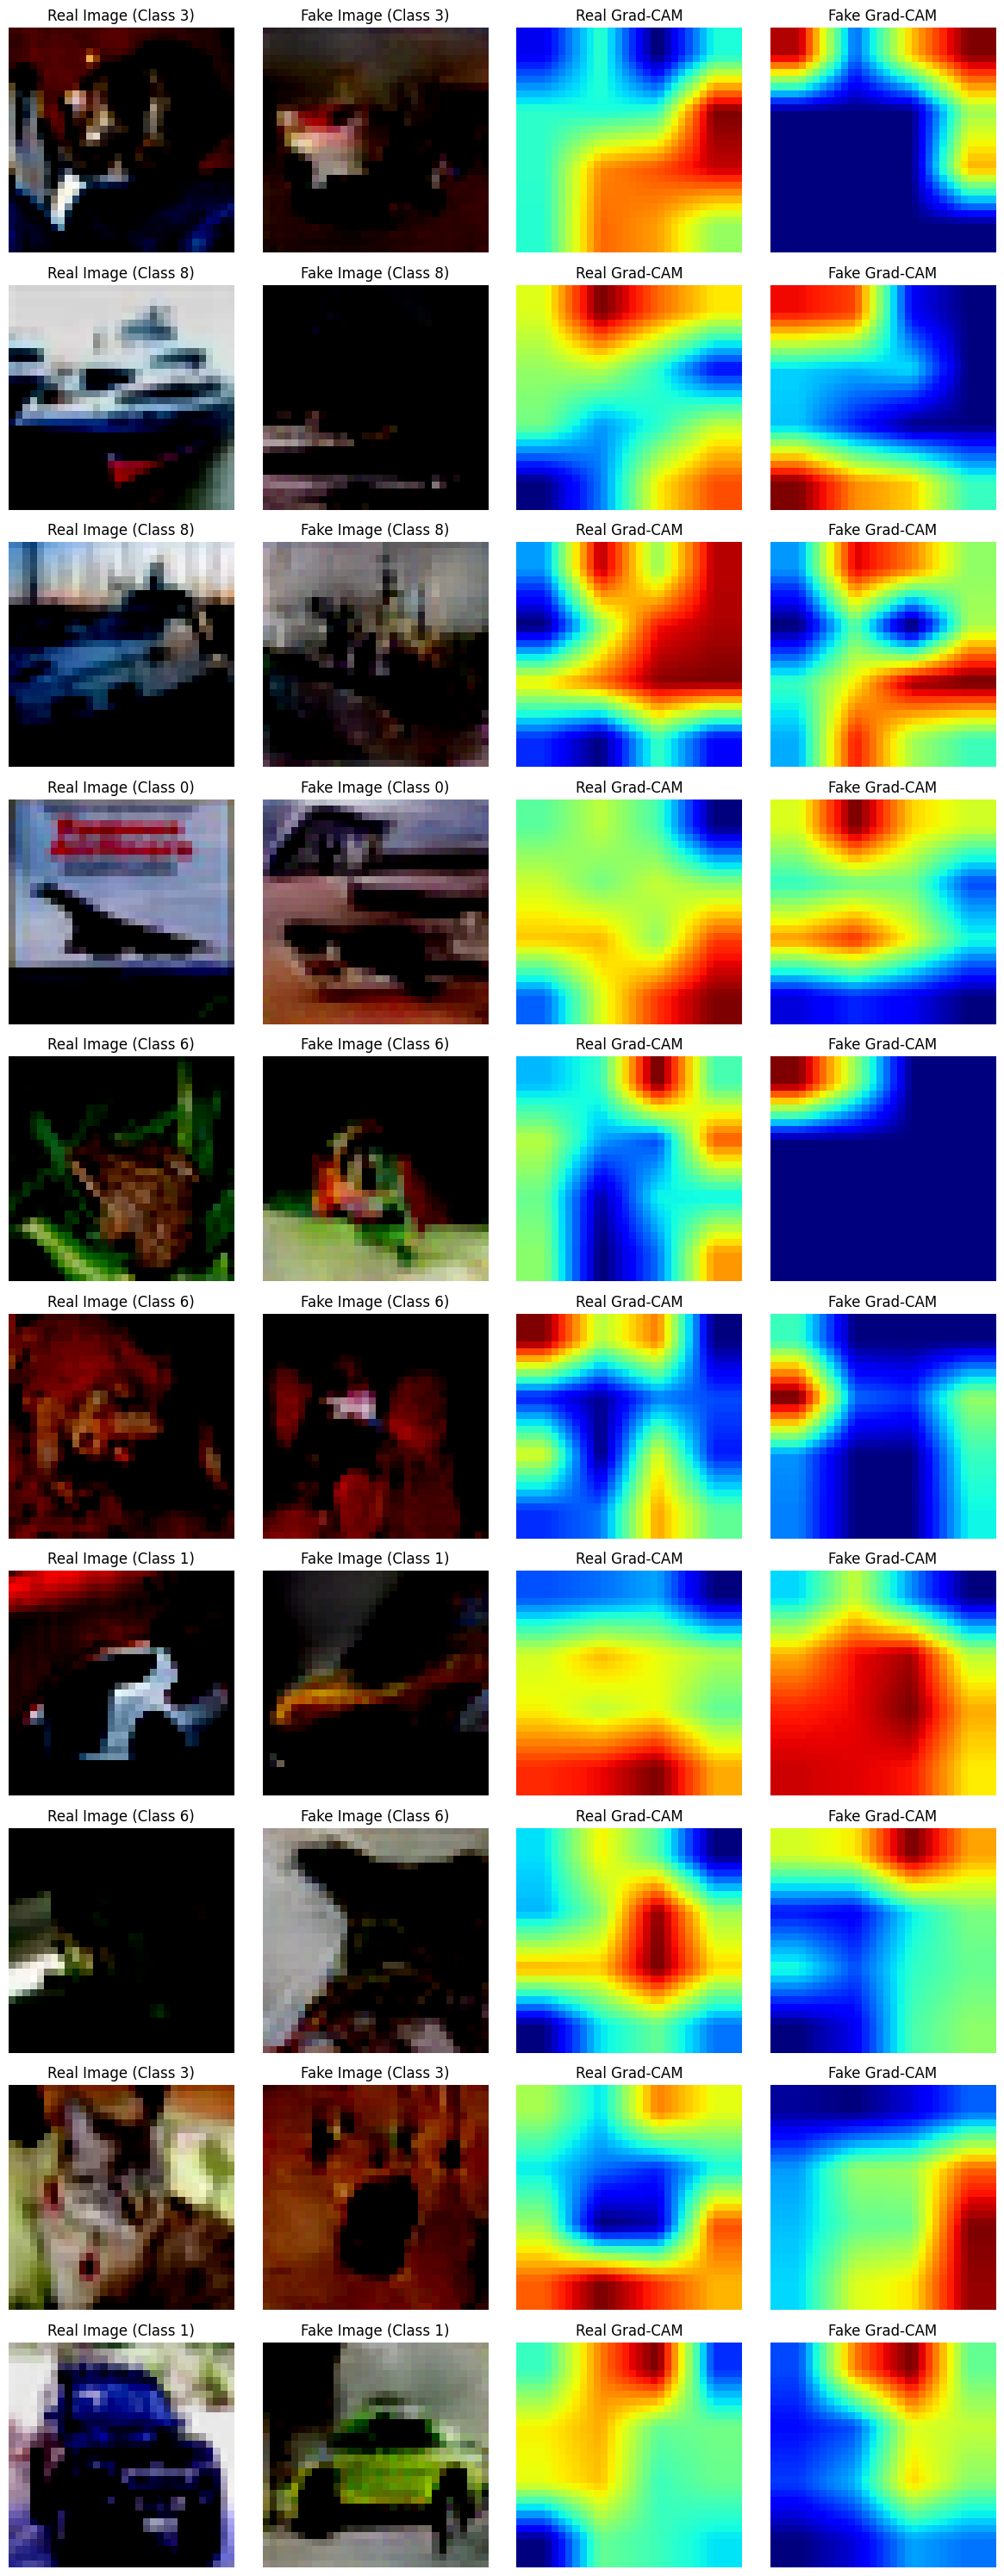

In [63]:
fig, axes = plt.subplots(num_pairs, 4, figsize=(12, 3 * num_pairs))

for i, (real_image, fake_image, real_label) in enumerate(real_fake_pairs):
    real_image_np = real_image.squeeze().permute(1, 2, 0).cpu().numpy()
    fake_image_np = fake_image.squeeze().permute(1, 2, 0).cpu().numpy()

    #Grad-CAM heatmaps
    real_heatmap = generate_gradcam_heatmap(real_image, real_label)
    fake_heatmap = generate_gradcam_heatmap(fake_image, real_label)

    real_heatmap_resized = np.resize(real_heatmap, (32, 32))
    fake_heatmap_resized = np.resize(fake_heatmap, (32, 32))

    axes[i, 0].imshow(real_image_np)
    axes[i, 0].set_title(f"Real Image (Class {real_label})")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(fake_image_np)
    axes[i, 1].set_title(f"Fake Image (Class {real_label})")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(real_heatmap, cmap="jet")
    axes[i, 2].set_title("Real Grad-CAM")
    axes[i, 2].axis("off")

    axes[i, 3].imshow(fake_heatmap, cmap="jet")
    axes[i, 3].set_title("Fake Grad-CAM")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()
